In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch

from gptopt.optim.attn_kq import *
from gptopt.optim.nesterov import *
from utils import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Smooth relaxation of primal problem
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G, Z \rangle + \frac{1}{2\mu }\|(|\mathcal{A}(Z)| - \beta)_+\|_F^2
\end{array}  
$$

## Nesterov for primal problem
$$
\begin{align}
\nabla f(U^k) &= G + \frac{1}{\mu} \mathcal{A}^*\left (\mathcal{A}(U^k) 
- \Pi_{[-\beta, \beta]}(\mathcal{A}(U^k))\right ) \\
Z^{k+1} &= U^k - \frac{\mu}{{\|\mathcal{A}\|_{\operatorname{op}}^2}} \nabla f(U^k) \\
U^{k+1} &= Z^{k+1} + \frac{k-1}{k+2} (Z^{k+1} - Z^k)
\end{align}
$$

In [3]:
n_head = 4
std1 = 1
std2 = 1
rank_ratio = 0.5

In [6]:
for (m, n) in [(20, 15), (15, 20), (15, 15)]:
    for _ in range(2):
        A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True, dtype=torch.float64)
        beta = 1

        A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
        Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)
        mu_max = A_linop.mv(Grad).abs().max().item() / beta
        mu_reg = mu_max * 0.1   

        Grad_np = Grad.cpu().numpy()
        Z0, obj0 = cvxpy_lmax_smooth_heads(Grad_np, A_linop, beta, n_head, mu_moreau=mu_reg)
        Z_cvxpy = torch.from_numpy(Z0).to(device).to(Grad.dtype)

        Z_t, residuals = nesterov_lmax_moreau(
                A_linop=A_linop, Grad=Grad,
                beta=beta, mu=mu_reg, 
                max_iter=10000,
                eps_abs=1e-8, eps_rel=1e-8, stopping=False,
                pd_residuals=pd_residuals_max_ball_linop
            )
        assert residuals["r_rel"][-1] < 1e-4 
        assert np.allclose(residuals['primal_vals'][-1], obj0, rtol=1e-4)
        
        assert np.allclose(
            (Z0 * Grad_np).sum(), (Z_t * Grad).sum().item(),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.allclose(torch.max(torch.abs(A_linop.matvec(Z_t))).item(),
               torch.max(torch.abs(A_linop.matvec(Z_cvxpy))).item(), rtol=1e-3)


print("PASSED")

PASSED


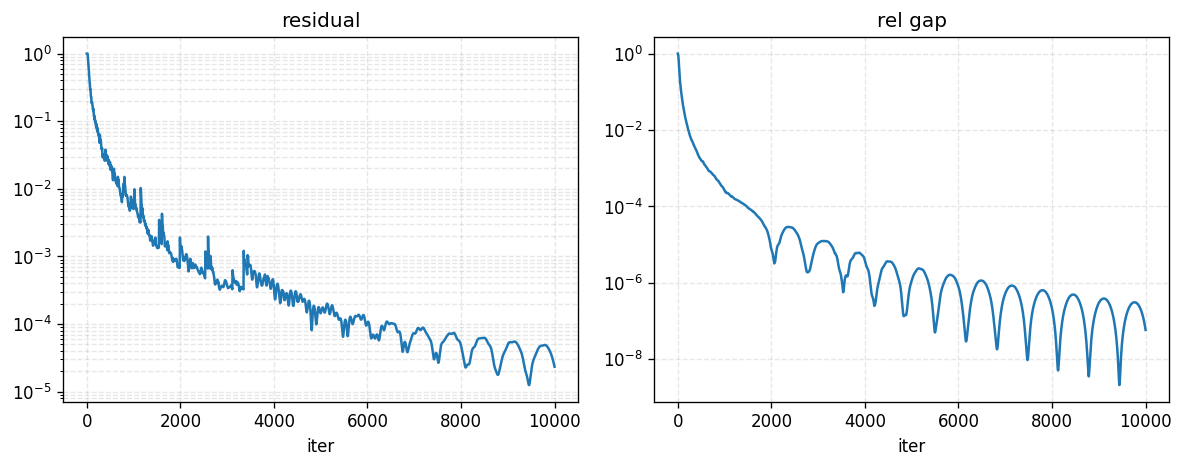

In [7]:
def plot_residuals_and_gap(logging, obj0):
    r = np.array(logging["r_rel"])
    loss = np.array(logging["primal_vals"])
    gap = np.abs(loss - obj0) / max(1.0, abs(obj0))
    it = np.arange(1, len(r) + 1)
   
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=120)
    ax[0].plot(it, r);    ax[0].set_yscale("log"); ax[0].set_title("residual"); ax[0].set_xlabel("iter")
    ax[1].plot(it, gap);  ax[1].set_yscale("log"); ax[1].set_title("rel gap");  ax[1].set_xlabel("iter")
    for a in ax: a.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()

    
plot_residuals_and_gap(residuals, obj0)

In [8]:
mu_reg

1.1750566140281211

#  $m=n=50$

In [9]:
m = n = 50
std2 = 1  
A2, A1, G1, G2 = gaussian_data_heads(m, n, n_head=n_head, std1=std1, std2=std2, 
                                            rank_ratio=rank_ratio, G_in_range=True, dtype=torch.float64)

A_linop = attn_linop_from_matrices_heads(A1, A2, n_head=n_head)
Grad = Z1_Z2_pack_Z_heads(G1, G2, n_head=n_head)

mu_max = A_linop.mv(Grad).abs().max().item() / beta
mu_reg = mu_max * 0.01
 

print(f"{mu_max=:.4e}, {A_linop.fro_norm=:.4e}")

mu_max=1.3751e+01, A_linop.fro_norm=7.1040e+01


In [10]:
Grad_np = Grad.cpu().numpy()
Z_star, f_star = cvxpy_lmax_smooth_heads(Grad_np, A_linop, beta, n_head, mu_moreau=mu_reg)

In [11]:
Z_t, residuals = nesterov_lmax_moreau(
                A_linop=A_linop, Grad=Grad,
                beta=beta, mu=mu_reg, 
                max_iter=10000,
                eps_abs=1e-8, eps_rel=1e-8, stopping=False,
                pd_residuals=pd_residuals_max_ball_linop)

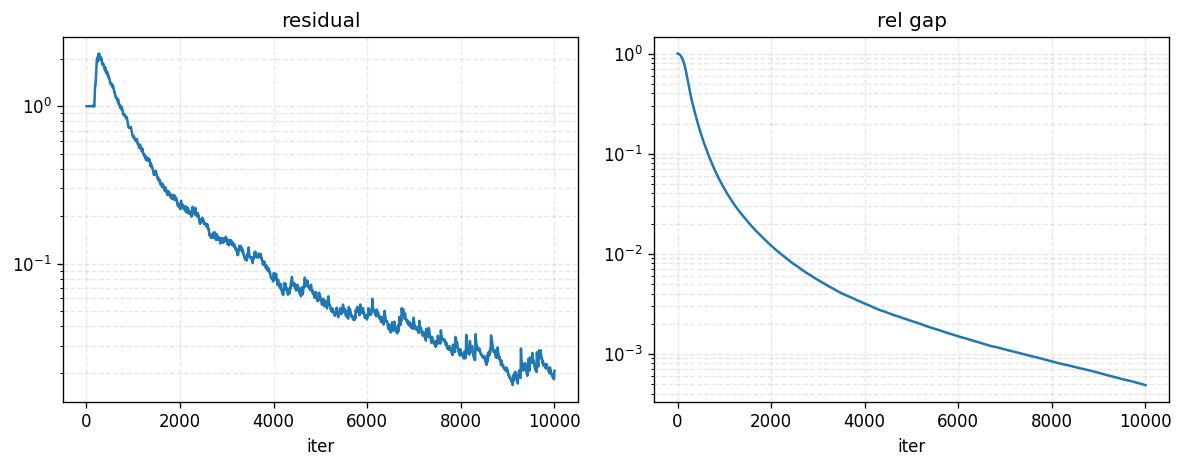

In [12]:
plot_residuals_and_gap(residuals, f_star)

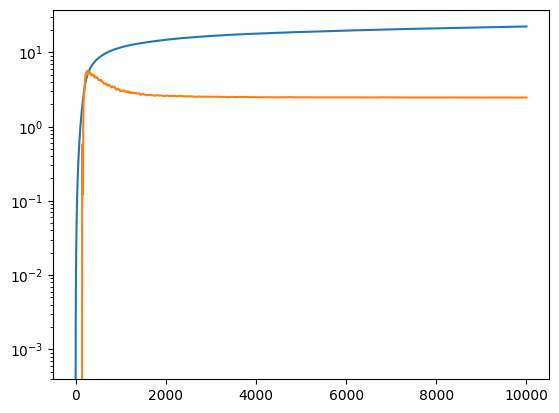

In [13]:
plt.plot(residuals["z_norm"], label="z_norm")
plt.plot(residuals["y_norm"], label="y_norm")
plt.yscale("log")

In [14]:
f_star

np.float64(-198.92729218086336)